# **Monotonization of Gaussian Processes**

## Motivation for analysis

In paleoclimatology, constructing accurate time series from proxy records requires precise age-depth modeling. These relationships are inherently monotonic, yet standard Gaussian Processes (GPs) do not enforce such constraints. This project implements the method proposed by Riihimäki and Vehtari (2010), which introduces monotonicity into GPs using virtual derivative observations and Expectation Propagation (EP).The model is built using the GPy Python library and tested on synthetic data. Results show that the method effectively incorporates prior knowledge about monotonic trends while maintaining the flexibility of nonparametric GP models.

## Introduction to Gaussian Processes

Gaussian Processes (GPs) provide a principled, non-parametric **Bayesian approach to regression**.  
They model distributions over functions, offering both a predictive mean and an uncertainty estimate at each test point.  

Formally, a GP is a collection of random variables, any finite subset of which follows a **multivariate Gaussian distribution**.  
A GP is fully specified by its mean function:

$$
m(x) = \mathbb{E}[f(x)]
$$

and its covariance function (or kernel):

$$
k(x, x') = \mathbb{E}[(f(x) - m(x))(f(x') - m(x'))]
$$

The choice of covariance function (also known as the **kernel**) defines the properties of functions drawn from the GP.  
For instance, the **squared exponential (or RBF) kernel** encodes the assumption that the function is infinitely differentiable and smooth.


## Procedure

The following steps were implemented to apply **Gaussian Process regression with monotonicity information**, as described by *Riihimäki and Vehtari [5]*:

---

#### **1. Generate Synthetic Data**
A target function was and Gaussian noise was added to simulate realistic observations.  
Inputs \( X \) were sampled uniformly in the interval \([0, \pi/2]\).

---

#### **2. Construct Standard GP Model**
A baseline Gaussian Process model was built using the **squared exponential (RBF) kernel**.  
This model was trained on the noisy data to produce unconstrained predictions.

---

#### **3. Define Monotonicity Directions**
A monotonicity constraint was enforced in the positive \( X \)-direction by specifying a vector  
\( \text{nvd} = [1, 0] \), indicating that the function is expected to be **non-decreasing**.

---

#### **4. Introduce Virtual Derivative Points**
Virtual inputs \( X_v \) were selected by sampling or **k-means clustering** over the input space.  
These points represent locations where monotonicity is encouraged via derivative observations.

---

#### **5. Construct Composite Likelihood**
A custom **likelihood function** was created that combines the Gaussian likelihood for real observations with a **Probit likelihood** for virtual derivative observations.  
This composite likelihood was attached to the GP model.

---

#### **6. Augment Training Data**
The dataset was augmented by stacking real observations and virtual derivative observations.  
Virtual targets were set to **+1** to reflect a preference for increasing slope.

---

#### **7. Optimize Model**
The model’s hyperparameters (kernel lengthscale, variance, noise level) were optimized using **gradient-based optimization** over the augmented data.

---

#### **8. Iterative Refinement**
If the predictive gradients violated the monotonicity assumption (i.e., predicted derivative < threshold), additional virtual points were added at the most violating locations.  
This loop was repeated until monotonicity violations disappeared or a maximum number of iterations was reached.

---

#### **9. Prediction and Visualization**
Both the monotonic and standard GP models were used to predict the function over a test grid.  
Mean functions and confidence intervals were plotted to compare their behaviors.


## Code

In [ ]:
# -----------------------------------------------------------
# Cell 2: Generate Synthetic Data
# -----------------------------------------------------------

# Set random seed for reproducibility
np.random.seed(42)

# Generate 50 random input points X uniformly between 0.1 and 6
# The [:, None] reshapes X into a column vector (N x 1) as required by GPy
X = np.sort(np.random.uniform(0.1, 6, 50))[:, None]

# Define a step-like target function:
# - Y = 0.0 for X < 3
# - Y = 0.5 for X >= 3
# Add small Gaussian noise (std = 0.05) to make data realistic
Y = np.where(X < 3, 0.0, 0.5) + 0.05 * np.random.randn(*X.shape)

# -----------------------------------------------------------
# Visualization
# -----------------------------------------------------------

plt.figure(figsize=(6, 3))
plt.plot(X, Y, 'kx')               # Plot data points as black crosses
plt.title('Training data (step-like)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# The resulting plot shows noisy step-like data,
# which will be used to train the Gaussian Process models.



In [ ]:
# -----------------------------------------------------------
# Cell 3: Construct Base GP and Monotonic GP Models
# -----------------------------------------------------------

# --- Step 2: Construct Standard GP Model ---
# Define the covariance (kernel) function.
# Using an RBF (Radial Basis Function) kernel, also known as the Squared Exponential kernel.
# - input_dim = 1 → single input variable
# - variance controls the function’s vertical scale
# - lengthscale controls the smoothness (larger = smoother)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=2.0)

# Create the baseline (unconstrained) Gaussian Process regression model.
# This model will learn from the noisy training data (X, Y)
# without any monotonicity information.
base_model = GPy.models.GPRegression(X, Y, kernel)

# --- Step 3–5: Define Monotonicity + Virtual Derivatives + Composite Likelihood ---
# Construct a monotonic GP model using the custom helper function `gp_monotonic`.
# Parameters:
# - base_model : The unconstrained GP model to start from.
# - X, Y       : Training data (inputs and targets).
# - nvd        : Monotonicity direction vector; [1.0] enforces monotonicity in positive X-direction.
# - nu         : A small jitter term (1e-8) to ensure numerical stability.
# - nv         : Number of virtual derivative points to introduce (for enforcing monotonicity).
# - force=True : Ensures virtual derivative points are added even if not required initially.
# - display=True : Prints optimization and progress information.
# - optimize='on' : Enables hyperparameter optimization after augmentation.
# - init='sample' : Strategy to initialize virtual derivative locations (sampling from X range).

mono_model = gp_monotonic(
    base_model,
    X, Y,
    nvd=[1.0],
    nu=1e-8,
    nv=10,
    force=True,
    display=True,
    optimize='on',
    init='sample'
)

# The resulting 'mono_model' is a Gaussian Process model with
# built-in monotonicity constraints, following Riihimäki & Vehtari (2010).
# This corresponds to Steps 2–5 in the algorithm:
# - Construct base GP
# - Define monotonic direction
# - Introduce virtual derivative points
# - Combine likelihoods for real and virtual observations



In [ ]:
# -----------------------------------------------------------
# Cell 4: Standard GP for Comparison
# -----------------------------------------------------------

# --- Step 2 (continued): Baseline GP model without monotonic constraints ---

# Create a new standard GP regression model using the same RBF kernel.
# The kernel is copied to avoid sharing hyperparameters with the monotonic model.
standard_gp = GPy.models.GPRegression(X, Y, kernel.copy())

# Set the Gaussian noise variance (observation noise level).
# A smaller value (0.01) indicates relatively low observation noise.
standard_gp.Gaussian_noise.variance = 0.01

# Optimize the hyperparameters (kernel variance, lengthscale, and noise variance)
# by maximizing the marginal likelihood.
# 'messages=True' displays optimization progress in the console.
standard_gp.optimize(messages=True)

# This model serves as the **baseline GP**, used later to compare
# against the **monotonic GP** model in terms of predictions and uncertainty.
# It corresponds to the standard (unconstrained) case in the Riihimäki & Vehtari framework.



In [ ]:
# -----------------------------------------------------------
# Cell 5: Predictions, Plotting, and Saving Result
# -----------------------------------------------------------

# --- Step 9: Prediction and Visualization ---

# Generate a dense test grid of 200 points between 0.1 and 6
# to evaluate the GP models over the input range.
Xtest = np.linspace(0.1, 6, 200)[:, None]

# Predict mean and variance for the monotonic GP model
# (exclude likelihood noise for smoother mean function)
mu_mono, var_mono = mono_model.predict(Xtest, full_cov=False, include_likelihood=False)

# Predict mean and variance for the standard (unconstrained) GP model
mu_standard, var_standard = standard_gp.predict(Xtest, full_cov=False, include_likelihood=False)

# -----------------------------------------------------------
# Data shaping and stability adjustments
# -----------------------------------------------------------

# Ensure mean and variance arrays have consistent 1D shapes
mu_mono = mu_mono[:, 0]
var_mono = np.clip(var_mono.squeeze(), 1e-6, None)         # Avoid negative/zero variances

mu_standard = mu_standard[:, 0]
var_standard = np.clip(var_standard.squeeze(), 1e-6, None)

# -----------------------------------------------------------
# Plotting: Monotonic GP vs Standard GP
# -----------------------------------------------------------

plt.figure(figsize=(10, 6))

# Training data (black crosses)
plt.plot(X, Y, 'kx', label="Training Data (Step Function)")

# --- Monotonic GP prediction ---
plt.plot(Xtest, mu_mono, '-', label="Monotonic GP Mean")
plt.fill_between(
    Xtest.ravel(),
    mu_mono - 2 * np.sqrt(var_mono),
    mu_mono + 2 * np.sqrt(var_mono),
    alpha=0.2, label="Monotonic GP 95% CI"
)

# --- Standard GP prediction ---
plt.plot(Xtest, mu_standard, '--', label="Standard GP Mean")
plt.fill_between(
    Xtest.ravel(),
    mu_standard - 2 * np.sqrt(var_standard),
    mu_standard + 2 * np.sqrt(var_standard),
    alpha=0.2, label="Standard GP 95% CI"
)

# Add labels, title, and legend
plt.title("Monotonic GP vs. Standard GP (Step Function)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.tight_layout()

# -----------------------------------------------------------
# Step 9 (continued): Save the figure in the repo structure
# -----------------------------------------------------------

from pathlib import Path
import os

# Detect repository root (same logic as before)
repo_root = Path.cwd().parents[0] if (Path.cwd() / 'notebooks').exists() else Path.cwd()

# Ensure the 'results' folder exists
results_dir = repo_root / 'results'
os.makedirs(results_dir, exist_ok=True)

# Save the figure at high resolution
plot_path = results_dir / 'result_plot.png'
plt.savefig(plot_path, dpi=200)
plt.show()

print(f"Saved plot to: {plot_path.resolve()}")

# -----------------------------------------------------------
# Notes:
# The plot shows:
# - Training data (black x)
# - Monotonic GP (solid line, smoother transition)
# - Standard GP (dashed line, may violate monotonicity)
# - Shaded regions = 95% confidence intervals
# -----------------------------------------------------------

## Example Plots

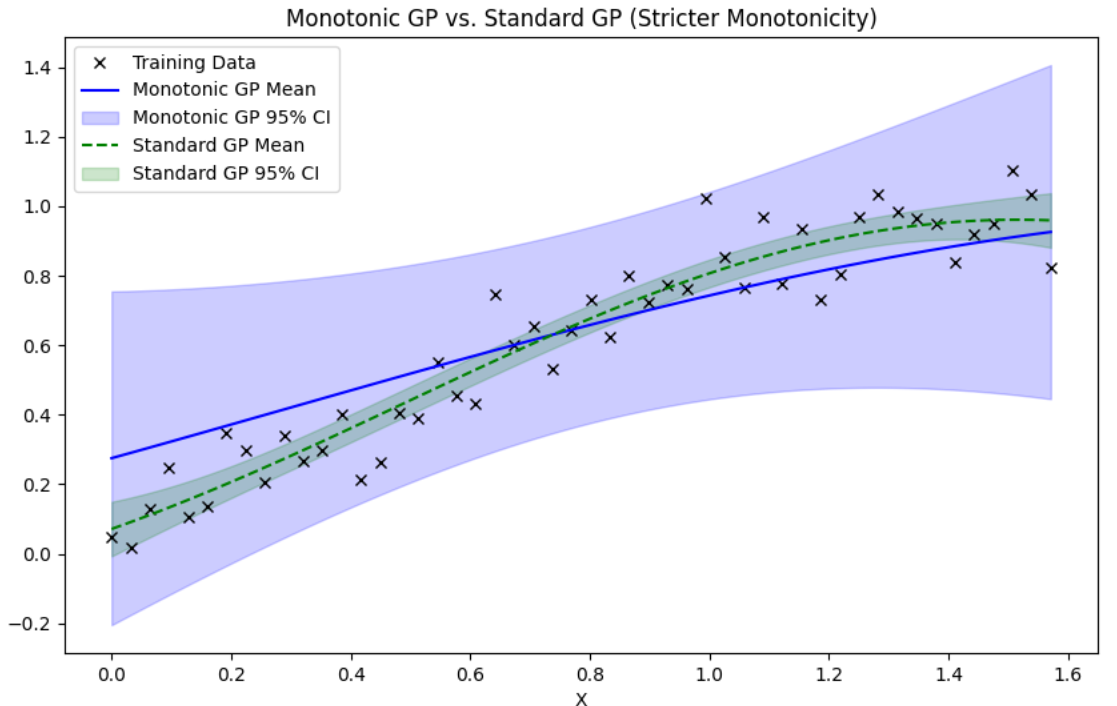

$$
Y = \sin(X), \quad X \in [0, \frac{\pi}{2}]
$$



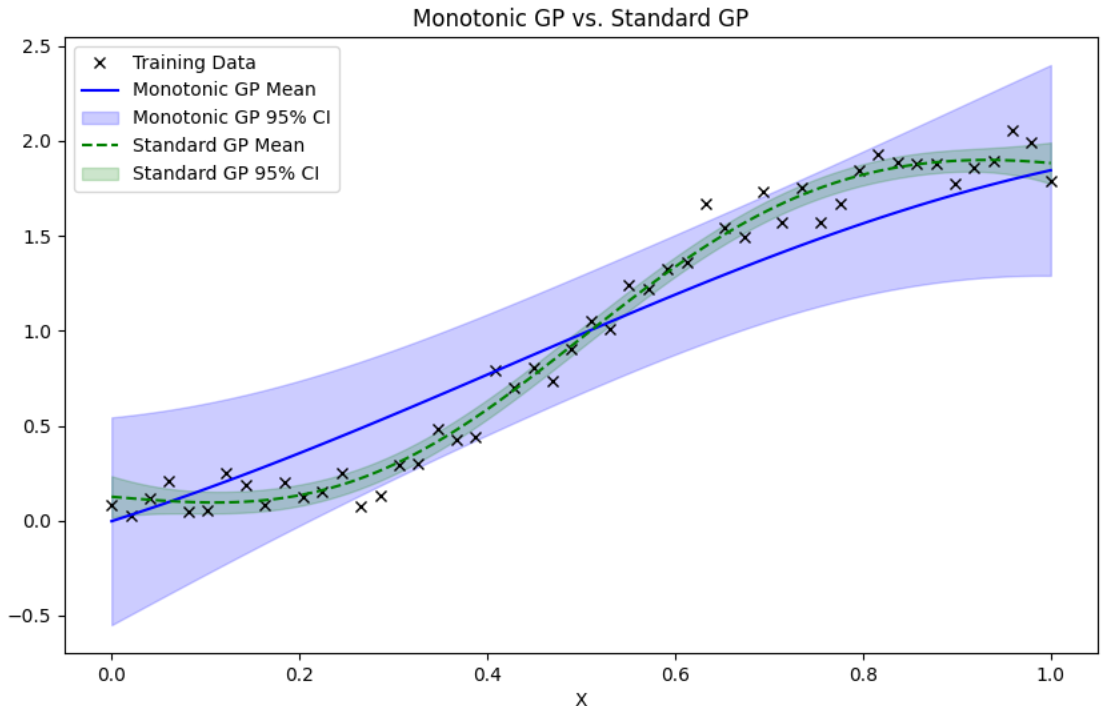

$$
Y = 2X
$$


